In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import time

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class ScaleShiftSelectTransform:
    def __call__(self, img):
        img_tensor = transforms.ToTensor()(img)
        if img_tensor.shape[0] > 3:
            img_tensor = img_tensor[:3, :, :]
        return 2 * img_tensor - 1
  

transform3 = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels
    ScaleShiftSelectTransform()  # Combined custom transform
])


transform1 = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors with values in [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5,0.5], std=[0.5, 0.5, 0.5,0.5])  # Normalize images to have values in [-1, 1]
    
])
transform2 = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors with values in [0, 1]
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images to have values in [-1, 1]
])

class dataset(Dataset):
    def __init__(self,path_x,path_y):
        self.path_x=path_x
        self.path_y=path_y
        self.x_imgs=sorted(os.listdir(path_x))
        self.y_imgs=sorted(os.listdir(path_y))
    def __len__(self):
        return len(self.x_imgs)
    
    def __getitem__(self,i):
        x_img_path=os.path.join(self.path_x,self.x_imgs[i])
        y_img_path=os.path.join(self.path_y,self.y_imgs[i])
#         print(x_img_path,y_img_path)
#         temp=Image.open(x_img_path)
#         print(np.array(temp).shape)
#         img_x=transform1(Image.open(x_img_path).convert("RGB"))
#         img_x=transform1(Image.open(x_img_path)) ## changed from above removed rgb taken 4 layers
        img_x=transform3(Image.open(x_img_path)) 
        img_y=transform2(Image.open(y_img_path))
        
        return img_x,img_y

In [4]:
def show_img(image_tensor):
    rgb_image_tensor = image_tensor[:3]
    image_array = rgb_image_tensor.numpy()
    plt.imshow(image_array.transpose(1, 2, 0))
    plt.axis('off')
    plt.show()

In [5]:
x_pth_train="/kaggle/input/deeplearning-ass2/dataset/images/train"
y_pth_train="/kaggle/input/deeplearning-ass2/dataset/masks/train"
x_pth_val="/kaggle/input/deeplearning-ass2/dataset/images/val"
y_pth_val="/kaggle/input/deeplearning-ass2/dataset/masks/val"
data_train=dataset(x_pth_train,y_pth_train)
data_val=dataset(x_pth_val,y_pth_val)
train_loader = DataLoader(data_train, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(data_val, batch_size=32, shuffle=False, num_workers=4)

In [7]:
class PositionalEmbedding(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        
        self.linear = nn.Linear(4, input_dim)

    def forward(self, cnn_feature_maps):
#         print("cnn feature map : ",cnn_feature_maps.shape)
        batch_size,_,height,width = cnn_feature_maps.shape
        
        # Construct positional embeddings tensor
        positional_embeddings = torch.zeros(batch_size, height, width, 4).to(device)
        for i in range(height):
            for j in range(width):
                positional_embeddings[:, i, j, 0] = j / (width - 1)  # Left
                positional_embeddings[:, i, j, 1] = i / (height - 1)  # Top
                positional_embeddings[:, i, j, 2] = (width - 1 - j) / (width - 1)  # Right
                positional_embeddings[:, i, j, 3] = (height - 1 - i) / (height - 1)  # Bottom
#         print(positional_embeddings[0,:,:,:])
#         print("before linear : ",positional_embeddings.shape)
        # Project positional embeddings to the same dimensionality as image feature vectors
        positional_embeddings = self.linear(positional_embeddings.view(batch_size * height * width, 4))
#         print("after linear : ",positional_embeddings.shape)
        positional_embeddings = positional_embeddings.view(batch_size, height, width, self.input_dim)
#         print("after reshape : ",positional_embeddings.shape)
        # Add positional embeddings to the original CNN feature maps
        augmented_feature_maps = cnn_feature_maps + positional_embeddings.view(batch_size,self.input_dim, height, width)
#         print("augmented_feature_maps: ",augmented_feature_maps.shape)
        return augmented_feature_maps

In [8]:
class encoder(nn.Module):
    def __init__(self,hid_dim=32):
        super().__init__()
        #self.conv1=nn.Conv2d(4,32,3,padding=1)
        #self.conv2=nn.conv2d(32,32,3,padding=1)
        #self.conv3=nn.conv2d(32,32,3,padding=1)
        self.conv1=nn.Conv2d(3,hid_dim,5,padding=2)  ############################### changed from 3 to 4
        self.conv2=nn.Conv2d(hid_dim,hid_dim,5,padding=2,stride=2)
        self.conv3=nn.Conv2d(hid_dim,hid_dim,5,padding=2,stride=2)
        self.conv4=nn.Conv2d(hid_dim,hid_dim,5,padding=2)
        self.nn1=nn.Linear(hid_dim,hid_dim)
        self.nn2=nn.Linear(hid_dim,hid_dim)
        self.layernorm=nn.LayerNorm(hid_dim)
#         print(hid_dim)
        self.position_embedding=PositionalEmbedding(input_dim=hid_dim)
    def forward(self,x):
#         print("input :",x.shape)
        x=self.conv1(x)
        x = F.relu(x)##################################################
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
#         print("conv out",x.shape)
        x=self.position_embedding(x) #x_with_position_embedding
        x=(torch.flatten(x,2,3)).permute(0,2,1) #x_flatten
        x=self.layernorm(x) #layer_norm_out
        x=self.nn2(F.relu(self.nn1(x))) #final_x
        
#         print("final encoder out : ",x.shape)
#         print("flatten : ",torch.flatten(x_with_position_embedding,2,3).shape)
        return x

In [9]:
class slot_attention(nn.Module):
    def __init__(self,hid_dim=64,k=11,iterations=3):
        super().__init__()
        self.layernorm=nn.LayerNorm(hid_dim)
        self.mu=nn.Parameter(torch.randn(1, 1, hid_dim))
        self.sigma=nn.Parameter(torch.rand(1, 1, hid_dim))
        self.k=k
        self.iterations=iterations
        self.q_matrix=nn.Linear(hid_dim,hid_dim)
        self.k_matrix=nn.Linear(hid_dim,hid_dim)
        self.v_matrix=nn.Linear(hid_dim,hid_dim)
        self.layernorm_slot1=nn.LayerNorm(hid_dim)
        self.layernorm_slot2=nn.LayerNorm(hid_dim)
        self.gru=nn.GRUCell(hid_dim,hid_dim)
        self.ff=nn.Linear(hid_dim,hid_dim)
    def forward(self,encoder_out):
#         print("encoder_out : ",encoder_out.shape)
        layernorm_out=self.layernorm(encoder_out)
#         print("layernorm_out shape :",layernorm_out.shape)
        b,n,d=layernorm_out.shape
        
        mu = self.mu.expand(b, self.k, -1)
        sigma = self.sigma.expand(b, self.k, -1)
#         print(f"mu shape : {mu.shape} sigma shape {sigma.shape}")
#         print(torch.min(mu),torch.max(mu),torch.min(sigma),torch.max(sigma))
        slots= torch.normal(mu,sigma)
#         print("slot shape : ",slots.shape)
        k_out=self.k_matrix(layernorm_out)
        v_out=self.v_matrix(layernorm_out)
        for i in range(self.iterations):
            slot_previous=slots.clone()
            slots=self.layernorm_slot1(slots)
            
           
            q_out=self.q_matrix(slots)
            
#             print(f"k_out : {k_out.shape} q_out : {q_out.shape} v_out : {v_out.shape}")
            
            attention_weights=(torch.einsum('bid,bjd->bij', k_out, q_out) * (d ** -0.5)).softmax(dim=2)+(1e-8)
#             print(f"attention_weights : {attention_weights.shape}")
            attention_weights = attention_weights / attention_weights.sum(dim=1, keepdim=True)
#             print(f"attention_weights after normalize : {attention_weights.shape}")
            updates=torch.einsum('bnd,bnk->bkd', v_out, attention_weights)
#             print(f"updates : {updates.shape}")
            slots=(self.gru(updates.reshape(-1,d),slot_previous.reshape(-1,d))).reshape(b,-1,d)
#             print(f"slots : {slots.shape}")
            slots=F.relu(self.ff(self.layernorm_slot2(slots)))+slots
            
#             break
#         print(f"final_out slot attention  : {slots.shape}")
        return slots
        
        

In [10]:
class decoder(nn.Module):
    def __init__(self,hid_dim=64):
        super().__init__()
        self.hid_dim=hid_dim
        self.position_embedding=PositionalEmbedding(input_dim=hid_dim)
        layers=[]
        for _ in range(4):
            layers.append(nn.ConvTranspose2d(hid_dim,hid_dim,kernel_size=5,stride=(2,2),padding=2,output_padding=1))
            layers.append(nn.ReLU())
        self.upscale=nn.Sequential(*layers)
        self.get_to_four_feature_space=nn.ConvTranspose2d(hid_dim,4,kernel_size=3,stride=(1,1),padding=1,output_padding=0)
        self.relu=nn.ReLU()
    def forward(self,x):
        x=(x.unsqueeze(2).unsqueeze(2).repeat(1,1,8,8,1)).view(-1,8,8,self.hid_dim).permute(0,3,1,2) #add_dim_repeat
#         print("add_dim_repeat : ",add_dim_repeat.shape)
        x=self.position_embedding(x) #add_pos_emdedd
#         print("add_pos_emdedd : ",add_pos_emdedd.shape)
        x=self.get_to_four_feature_space(self.upscale(x)) #conv_final
#         print("decoder out : ",conv_final.shape)
        return x
        
    
class SpatialBroadcastDecoder(nn.Module):
    def __init__(self, feature_dim, output_channels, height, width):
        super(SpatialBroadcastDecoder, self).__init__()
        self.feature_dim = feature_dim
        self.output_channels = output_channels
        self.height = height
        self.width = width
        
        # Define the layers of the network
        self.conv1 = nn.Conv2d(feature_dim + 2, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, output_channels, kernel_size=1)  

    def forward(self, x):
        batch_size, num_features, feature_dim = x.shape
        x = x.view(batch_size * num_features, feature_dim, 1, 1).repeat(1, 1, self.height, self.width)
        gx, gy = torch.meshgrid(torch.linspace(-1, 1, self.width), torch.linspace(-1, 1, self.height), indexing='xy')
        gx = gx.to(x.device)
        gy = gy.to(x.device)
        gx = gx.repeat(batch_size * num_features, 1, 1).unsqueeze(1) 
        gy = gy.repeat(batch_size * num_features, 1, 1).unsqueeze(1)  

        x = torch.cat([x, gx, gy], dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x) 
        return x.view(batch_size, num_features, self.output_channels, self.height, self.width)


In [11]:
class slot_model(nn.Module):
    def __init__(self,hid_dim=64,output_channels=4,img_height=128):
        super().__init__()
        self.encoder=encoder(hid_dim=hid_dim)
        self.slot_att=slot_attention(hid_dim=hid_dim)
#         self.decoder=decoder(hid_dim=hid_dim)
        self.decoder = SpatialBroadcastDecoder(feature_dim=hid_dim, output_channels=output_channels, height=img_height, width=img_height)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,x):
        b,d,h,w=x.shape
#         print("model input shape : ",b,d,h,w)
        enc_out=self.encoder(x)
        slots=self.slot_att(enc_out)
#         print(slots.shape)
#         decode_out=self.decoder(slots).view(b,-1,d,h,w).permute(0,1,3,4,2)
        decode_out=self.decoder(slots).permute(0,1,3,4,2)
#         print("after reshape and permute :",decode_out.shape)
        final_mask,final_image=decode_out.split([1,3],dim=4)
#         print(f"final_image : {final_image.shape},final_mask : {final_mask.shape}")
        prob_mask=self.softmax(final_mask)
        multiply_mask_fin_img=final_image*prob_mask
#         print(f"multiply_mask_fin_img : {multiply_mask_fin_img.shape}")
        recombine_image=(torch.sum(multiply_mask_fin_img,dim=1)).permute(0,3,1,2)
#         print(f"recombine_image : {recombine_image.shape}")
        return recombine_image ,slots , final_image.permute(0,1,4,2,3),prob_mask
        

In [12]:
model=slot_model().to(device)

In [16]:
infer_data = DataLoader(data_train, batch_size=1, shuffle=False, num_workers=4)

In [ ]:
def normalize_image(img):
    """Normalize the image data to 0-1 range."""
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)

def plot_images(images):
    fig, axs = plt.subplots(1, len(images) , figsize=(24, 2)) 

    for idx, img in enumerate(images):
        img = normalize_image(img)  # Normalize each image
        img = img.permute(1, 2, 0)
        axs[idx ].imshow(img.cpu().detach().numpy())  # Offset index by 2 now
        axs[idx ].axis('off')

    plt.show()
def infer(p,n):
    model.eval()
    i=0
    for ct,(x,y) in enumerate(infer_data):
        x=x.to(device)
        out,mask=model(x)
        mask=mask.squeeze(-1).squeeze(0)
        out=out.squeeze(0)
        print(out.shape,mask.shape)
        imgs=[]
        imgs.append(x.squeeze(0))
        imgs.append(out)
        
        for i in range(11):
            imgs.append(out*mask[i])
        plot_images(imgs)
        if(n==ct+1):
            break

loss_train : 0.08819209286272525 loss_val : 0.07589085764302232  time : 12.0 


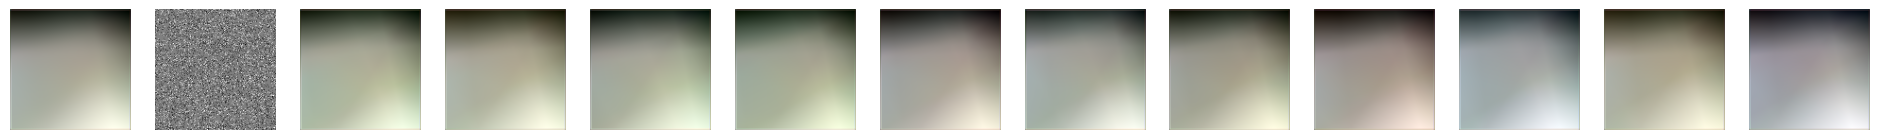

loss_train : 0.07473261702954768 loss_val : 0.0713348541849147  time : 25.0 
loss_train : 0.07066941892802715 loss_val : 0.06785646254738299  time : 37.0 
loss_train : 0.06759061797857284 loss_val : 0.06531579448535038  time : 49.0 
loss_train : 0.06530840372443199 loss_val : 0.06342006243836766  time : 62.0 
loss_train : 0.06372109734117985 loss_val : 0.06195000469827423  time : 74.0 
loss_train : 0.062476715609431265 loss_val : 0.061061008824422336  time : 87.0 
loss_train : 0.061348317450284955 loss_val : 0.06012487593597878  time : 99.0 
loss_train : 0.060113465684652326 loss_val : 0.058587087371859685  time : 111.0 
loss_train : 0.05883830800354481 loss_val : 0.05721029010824502  time : 124.0 
loss_train : 0.05745836694836617 loss_val : 0.05583298876405524  time : 136.0 


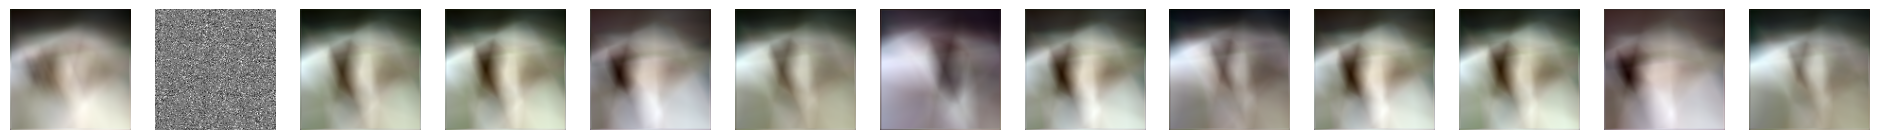

loss_train : 0.056055991488695146 loss_val : 0.0544579480164729  time : 149.0 
loss_train : 0.054400919434428215 loss_val : 0.05289810543623976  time : 161.0 
loss_train : 0.05252178635895252 loss_val : 0.05087294242681025  time : 173.0 
loss_train : 0.05064366568922996 loss_val : 0.049339997287565905  time : 186.0 
loss_train : 0.04913958571255207 loss_val : 0.04776065823988031  time : 198.0 
loss_train : 0.04789321097135544 loss_val : 0.04684819297763867  time : 211.0 
loss_train : 0.046739666900038716 loss_val : 0.04546006178608337  time : 223.0 
loss_train : 0.04575710322707891 loss_val : 0.04444751737359614  time : 235.0 
loss_train : 0.04483551169037819 loss_val : 0.04371440618897018  time : 248.0 
loss_train : 0.0440426716953516 loss_val : 0.043167062746450165  time : 260.0 


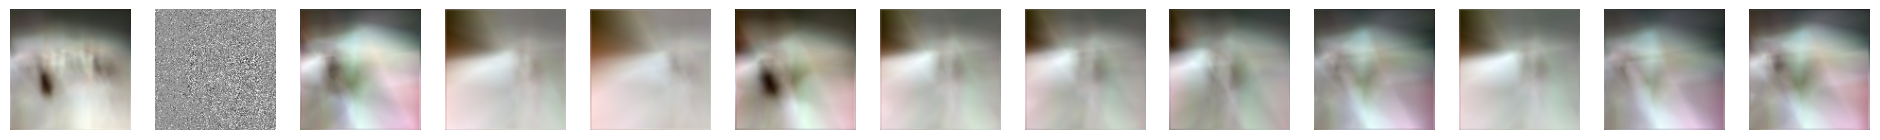

loss_train : 0.04334108540862799 loss_val : 0.042738149019952015  time : 273.0 
loss_train : 0.04274637072235346 loss_val : 0.042057693593751506  time : 285.0 
loss_train : 0.04218200627863407 loss_val : 0.04149022859077865  time : 297.0 
loss_train : 0.041682338014245035 loss_val : 0.04101168346433594  time : 310.0 
loss_train : 0.04121525904089213 loss_val : 0.04044575894626375  time : 322.0 
loss_train : 0.04076875279992819 loss_val : 0.040045918605198114  time : 334.0 
loss_train : 0.04038513266891241 loss_val : 0.03955586212345015  time : 347.0 
loss_train : 0.040005434986948966 loss_val : 0.03922401572735355  time : 359.0 
loss_train : 0.03959827345013618 loss_val : 0.03918083212650812  time : 371.0 
loss_train : 0.03926092137992382 loss_val : 0.038726036237499206  time : 384.0 


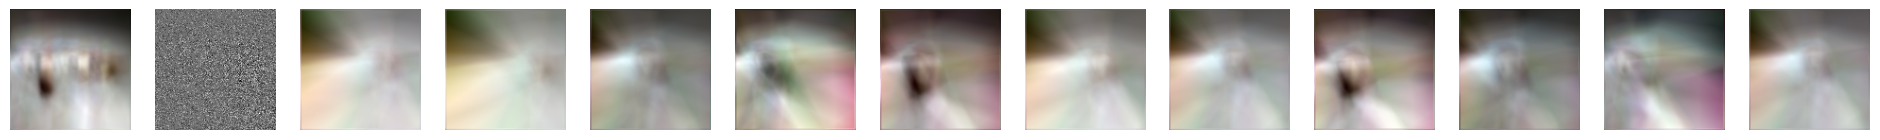

loss_train : 0.038982918448746205 loss_val : 0.03828509951147218  time : 396.0 
loss_train : 0.03866439542323351 loss_val : 0.03789472515090776  time : 409.0 
loss_train : 0.038397437706589696 loss_val : 0.03773394973871236  time : 421.0 
loss_train : 0.038127858704328534 loss_val : 0.037485796214340214  time : 433.0 
loss_train : 0.03787583410739899 loss_val : 0.03751251243126278  time : 446.0 
loss_train : 0.03768482763171196 loss_val : 0.03714059816357998  time : 458.0 
loss_train : 0.03745259214192629 loss_val : 0.036872428220015366  time : 471.0 
loss_train : 0.03724835459887981 loss_val : 0.03668917715549469  time : 483.0 
loss_train : 0.037109594537317755 loss_val : 0.036557306681340114  time : 495.0 
loss_train : 0.03687522945404053 loss_val : 0.0364122335581829  time : 508.0 


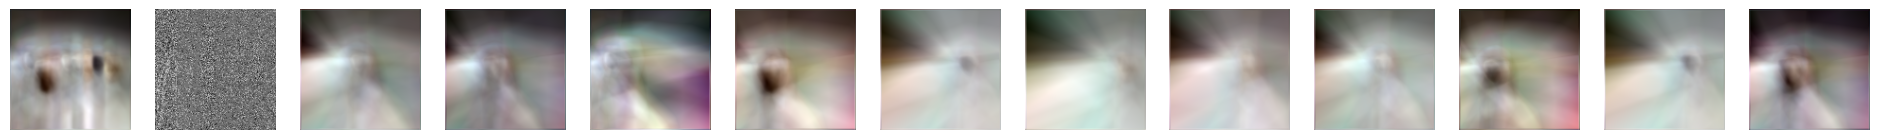

loss_train : 0.03674977458566427 loss_val : 0.03628059492681544  time : 520.0 
loss_train : 0.03655847794264555 loss_val : 0.03612291786117485  time : 532.0 
loss_train : 0.03640056837201119 loss_val : 0.035807335041106315  time : 545.0 
loss_train : 0.03624535885155201 loss_val : 0.03582514416033658  time : 557.0 


In [17]:
optimizer=optim.Adam(model.parameters(),lr=1e-4)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3,  min_lr=1e-7)
criterion=nn.MSELoss()
epoches=45
epoch_loss_train=[]
epoch_loss_val=[]
st=time.time()
final_slots=[]
for epoch in range(epoches):
    batch_loss_train=[]
    model.train()
    for i,(x,y) in enumerate(train_loader):
        x=x.to(device)
        out,slot,_,_=model(x)
        loss=criterion(out,x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss_train.append(loss.item())
        if(epoch==epoches-1):
            for one in slot:
                for slt in one:
                    final_slots.append(slt)
    epoch_loss_train.append(np.mean(batch_loss_train))
    
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': epoch_loss_train[-1],
    }
    torch.save(checkpoint, 'model_checkpoint.pth')
    model.eval()
    batch_loss_val=[]
    for i,(x,y) in enumerate(val_loader):
        x=x.to(device)
        out,_,_,_=model(x)
        loss=criterion(out,x)
        batch_loss_val.append(loss.item())
    epoch_loss_val.append(np.mean(batch_loss_val))
    scheduler.step(epoch_loss_val[-1])
    print(f"loss_train : {epoch_loss_train[-1]} loss_val : {epoch_loss_val[-1]}  time : {(time.time()-st)//60} ")

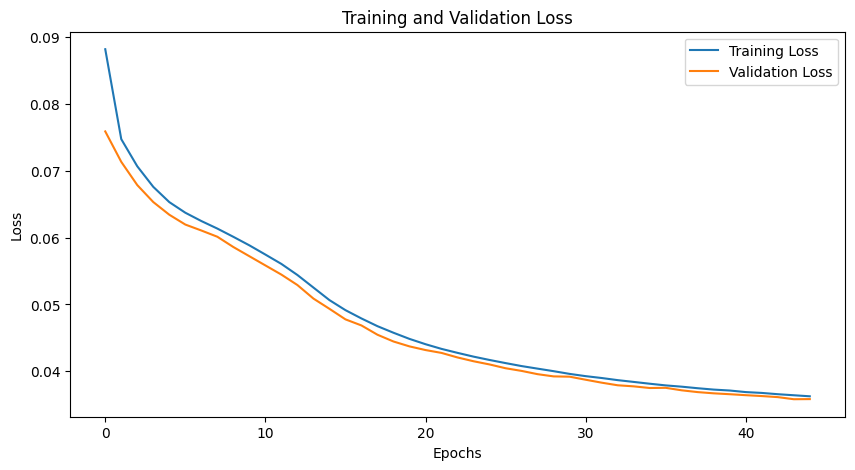

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_loss_train, label='Training Loss')
plt.plot(epoch_loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# should be done by loading the model

In [ ]:
class slot_model_infer(nn.Module):
    def __init__(self,hid_dim=64,output_channels=4,img_height=128,clusters=None):
        super().__init__()
        self.decoder = SpatialBroadcastDecoder(feature_dim=hid_dim, output_channels=output_channels, height=img_height, width=img_height)
        self.softmax = nn.Softmax(dim=1)
        self.clusters=clusters
        
    def forward(self):
        
        slots=self.get_random_slots()
#         print(slots.shape)
#         decode_out=self.decoder(slots).view(b,-1,d,h,w).permute(0,1,3,4,2)
        decode_out=self.decoder(slots).permute(0,1,3,4,2)
#         print("after reshape and permute :",decode_out.shape)
        final_mask,final_image=decode_out.split([1,3],dim=4)
#         print(f"final_image : {final_image.shape},final_mask : {final_mask.shape}")
        prob_mask=self.softmax(final_mask)
        multiply_mask_fin_img=final_image*prob_mask
#         print(f"multiply_mask_fin_img : {multiply_mask_fin_img.shape}")
        recombine_image=(torch.sum(multiply_mask_fin_img,dim=1)).permute(0,3,1,2)
#         print(f"recombine_image : {recombine_image.shape}")
        return recombine_image 

    def get_random_slots(self):
        slot=[]
        for i in range(11):
            slot.append(random.choice(self.clusters[i]))
        slot=torch.stack(slot, dim=0).to(device).unsqueeze(0)
        return slot
        

In [ ]:
def reshape_val(p):
    l=os.listdir(p)
    if os.path.exists("val"):
        os.rmdir("val")
    os.makedirs("val")
    path="/kaggle/working/val/"
    for i in range(len(l)):
        img_path=os.path.join(p,l[i])
#         print(img_path.shape)
        new_img=cv2.resize(cv2.imread(img_path),(128,128))
#         print(new_img.shape)
        cv2.imwrite(path+str(i)+".png",new_img)


In [ ]:
def perform_kmeans_clustering(data, n_clusters):
    data_matrix = torch.stack(data).numpy().reshape(-1, 64) 
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data_matrix)
    cluster_labels = kmeans.labels_
    clustered_data = [[] for _ in range(n_clusters)]
    for idx, label in enumerate(cluster_labels):
        clustered_data[label].append(data[idx])

    return clustered_data

In [ ]:
def gen_clusters_file():
    p="/kaggle/input/slot-checkpoint/model_checkpoint.pth"
    trained_model=torch.load(p)
    model=slot_model().to(device)
    model.load_state_dict(trained_model["model_state_dict"])
    model.eval()
    final_slots=[]
    for i,(x,y) in enumerate(tqdm(train_loader)):
        x=x.to(device)
        _,slots,_,_=model(x)
        for one in slots:
            for slt in one:
                final_slots.append(slt.detach().cpu())
        del(x)
    clusters=perform_kmeans_clustering(final_slots,11)
    with open('slot_tensors.pkl', 'wb') as f:
        pickle.dump(clusters, f)
    return clusters


In [ ]:
import shutil
def gen_metrics(trained_path,clusters):
    val_data_path="/kaggle/working/val"
    infered_path="/kaggle/working/infered"
    l=os.listdir(val_data_path)
    n=len(l)
    infer_model=slot_model_infer(clusters=clusters).to(device)
    trained_model=torch.load(trained_path)
    model_state_dict = trained_model["model_state_dict"]
    decoder_params = {k: v for k, v in model_state_dict.items() if k.startswith('decoder.')}
    infer_model.load_state_dict(decoder_params)
    infer_model.eval()
    if os.path.exists("infered"):
        shutil.rmtree("infered")
    os.makedirs("infered")
    for i in range(n):
        out=infer_model().squeeze(0)
        out=normalize_image(out)*255
        img=np.transpose(out.detach().cpu().numpy(),(1,2,0))
        img_path=os.path.join("/kaggle/working/infered",str(i)+".png")
#         print("imgae generated : ",i)
        cv2.imwrite(img_path,img)
    print("random imgs generated!!")
    paths = [val_data_path, infered_path]
    fid_value = calculate_fid_given_paths(paths, batch_size=50, device=device, dims=2048)
    
    return fid_value

In [ ]:
reshape_val("/kaggle/input/deeplearning-ass2/dataset/images/val")
clusters=gen_clusters_file()
p="/kaggle/input/slot-checkpoint/model_checkpoint.pth"
clean_fid=gen_metrics(p,clusters)
print(clean_fid)

In [ ]:

import torch 
import torch.nn.functional as F

def adjusted_rand_index(true_masks, pred_masks):
#     print("shapes : ",pred_masks.shape,true_masks.shape)
    """
    Args:
        true_masks: Integer ids for objects
            [batch_size, H, W].  
            as integer ids.
        pred_masks: An integer-valued array of shape
            [batch_size, K, H, W]. The predicted cluster assignment
            encoded as integer ids.
        ignore_background: Boolean, if True, then ignore all pixels where
            true_ids == 0 (default: False).

    Returns:
        ARI scores as a float32 array of shape [batch_size].
    """
    
    
#     print(torch.min(true_masks),torch.min(pred_masks))
#     print(torch.max(true_masks),torch.max(pred_masks))
    pred_masks = pred_masks.argmax(dim=-3)  # [B, N, H, W] --> [B, H, W]
    b=pred_masks.shape[0]
#     for i in range(b):
#         pred_masks[i]=normalize_image(pred_masks[i])*255
#     print("shapes : ",pred_masks.shape,true_masks.shape)
#     for i in range(b):
#         i1=pred_masks[i].detach().cpu().numpy()
#         plt.imshow(i1)
#         plt.show
    
#     print(torch.min(true_masks),torch.min(pred_masks))
#     print(torch.max(true_masks),torch.max(pred_masks))
    
    if len(true_masks.shape) == 3:
        true_masks = true_masks.unsqueeze(1)
    if len(pred_masks.shape) == 3:
        pred_masks = pred_masks.unsqueeze(1)

        
    true_masks = true_masks.long()
    pred_masks = pred_masks.long()
    
#     print(torch.min(true_masks),torch.min(pred_masks))
#     print(torch.max(true_masks),torch.max(pred_masks))

    
    true_oh = F.one_hot(true_masks).float()
    pred_oh = F.one_hot(pred_masks).float()

    N = torch.einsum("bthwc,bthwk->bck", true_oh, pred_oh)
    A = torch.sum(N, dim=-1)  # row-sum  (batch_size, c)
    B = torch.sum(N, dim=-2)  # col-sum  (batch_size, k)
    num_points = torch.sum(A, dim=1)

    rindex = torch.sum(N * (N - 1), dim=[1, 2])
    aindex = torch.sum(A * (A - 1), dim=1)
    bindex = torch.sum(B * (B - 1), dim=1)
    expected_rindex = aindex * bindex / torch.clamp(
        num_points * (num_points - 1), min=1)
    max_rindex = (aindex + bindex) / 2
    denominator = max_rindex - expected_rindex
    ari = (rindex - expected_rindex) / denominator

    # There are two cases for which the denominator can be zero:
    # 1. If both label_pred and label_true assign all pixels to a single cluster.
    #    (max_rindex == expected_rindex == rindex == num_points * (num_points-1))
    # 2. If both label_pred and label_true assign max 1 point to each cluster.
    #    (max_rindex == expected_rindex == rindex == 0)
    # In both cases, we want the ARI score to be 1.0:
    return torch.where(denominator != 0, ari, torch.tensor(1.).type_as(ari))

In [ ]:
model=model.to(device)
b=2
val_loader = DataLoader(data_val, batch_size=b, shuffle=False, num_workers=4)
def calculate_ari():
    ari=0
    for i,(x,y) in enumerate(tqdm(val_loader)):
        x=x.to(device)
        y=y.to(device)
        o,_,_,mask=model(x)
        print(mask.shape)
        ari+=torch.sum(adjusted_rand_index(y,mask))
    return(ari.item()/len(val_loader))

In [ ]:
ari=calculate_ari()
print(ari)